# Data Mining Project
by Obsa Aba-waji Mirnary Carbajal

## Experiment 1: Linear Regression
In this notebook, we will be looking at a comparison of gas prices with fuel economy. Our hypothesis is that increases in gas prices are what drive the increase in improvements of fuel economy.

In [1]:
%matplotlib inline

## Importing Libs and Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
vehicles = pd.read_csv('data/vehicles.csv', dtype=object)
weekly_gas_all_prices = pd.read_csv('data/GASALLCOVW.csv', index_col=0)
weekly_gas_reg_prices = pd.read_csv('data/GASREGCOVW.csv', index_col=0)
weekly_gas_prem_prices = pd.read_csv('data/GASPRMCOVW.csv', index_col=0)
annually_gas_all_prices = pd.read_csv('data/GASALLCOVA.csv', index_col=0)
annually_gas_reg_prices = pd.read_csv('data/GASREGCOVA.csv', index_col=0)
annually_gas_prem_prices = pd.read_csv('data/GASPRMCOVA.csv', index_col=0)

## Check to see that Vehicles Data has been loaded

Looking at the head of the data to make sure that the data has been loaded into their dataframes.

In [5]:
print("Shape of the Vehicles table is {}".format(vehicles.shape))
vehicles.head()

Shape of the Vehicles table is (39221, 83)


,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,...,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714285714287,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,29.96454545454546,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,12.207777777777778,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
3,29.96454545454546,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
4,17.347894736842107,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


## Cleaning up vehicles data

The vehicles data has a lot of fields that we will not be needing and is not ogranized in a logical manner for our needs.

In [6]:
columns_for_vehicles = ['year',
                        'make',
                        'model',
                        'VClass',
                        'fuelType',
                        'fuelType1',
                        'city08',
                        'highway08',
                        'comb08']
vehicles = vehicles[columns_for_vehicles]
vehicles.head()

,year,make,model,VClass,fuelType,fuelType1,city08,highway08,comb08
0,1985,Alfa Romeo,Spider Veloce 2000,Two Seaters,Regular,Regular Gasoline,19,25,21
1,1985,Ferrari,Testarossa,Two Seaters,Regular,Regular Gasoline,9,14,11
2,1985,Dodge,Charger,Subcompact Cars,Regular,Regular Gasoline,23,33,27
3,1985,Dodge,B150/B250 Wagon 2WD,Vans,Regular,Regular Gasoline,10,12,11
4,1993,Subaru,Legacy AWD Turbo,Compact Cars,Premium,Premium Gasoline,17,23,19


In [7]:
print(set(vehicles.fuelType1.values))

{'Electricity', 'Midgrade Gasoline', 'Natural Gas', 'Diesel', 'Regular Gasoline', 'Premium Gasoline'}


In [8]:
categorical_columns = ['make', 'VClass', 'fuelType', 'fuelType1']
numeric_columns = ['city08', 'highway08', 'comb08', 'year']

In [9]:
for col in vehicles.columns:
    if col in categorical_columns:
        vehicles[col] = pd.Categorical(vehicles[col])
        vehicles['{col}_codes'.format(col=col)] = vehicles[col].cat.codes
    elif col in numeric_columns:
        vehicles[col] = pd.to_numeric(vehicles[col])

In [10]:
vehicles.head()
vehicles['comb08'].corr(vehicles['year'])

0.19365073290913343

## Cleaning up Gasoline data

The next piece of data we need to clean up is our gas prices data. Our vehicle data has years prior to 1993, but the data is not complete, so we will be focusing on gas prices starting in 1994.
We will also be slicing the DATE index, so it only shows the year. And we will be renaming the index column from 'DATE' to 'year'

In [11]:
annually_gas_prem_prices['prem_velocity'] = annually_gas_prem_prices.diff()
annually_gas_all_prices['all_velocity'] = annually_gas_all_prices.diff()
annually_gas_reg_prices['reg_velocity'] = annually_gas_reg_prices.diff()

In [12]:
temp = annually_gas_all_prices.join(annually_gas_prem_prices)
joined_annually_gas_prices = temp.join(annually_gas_reg_prices)
len(joined_annually_gas_prices)

22

In [13]:
joined_annually_gas_prices.head()

,GASALLCOVA,all_velocity,GASPRMCOVA,prem_velocity,GASREGCOVA,reg_velocity
DATE,,,,,,
1995-01-01,1.144,NaN,1.287,NaN,1.103,0.031
1996-01-01,1.231,0.087,1.371,0.084,1.192,0.089
1997-01-01,1.228,-0.003,1.368,-0.003,1.189,-0.003
1998-01-01,1.056,-0.172,1.199,-0.169,1.017,-0.172
1999-01-01,1.156,0.100,1.297,0.098,1.116,0.099


In [14]:
joined_annually_gas_prices.index = joined_annually_gas_prices.index.astype(str).str[:4].astype(int)
joined_annually_gas_prices.index.names = ['year']
joined_annually_gas_prices.head()

,GASALLCOVA,all_velocity,GASPRMCOVA,prem_velocity,GASREGCOVA,reg_velocity
year,,,,,,
1995,1.144,NaN,1.287,NaN,1.103,0.031
1996,1.231,0.087,1.371,0.084,1.192,0.089
1997,1.228,-0.003,1.368,-0.003,1.189,-0.003
1998,1.056,-0.172,1.199,-0.169,1.017,-0.172
1999,1.156,0.100,1.297,0.098,1.116,0.099


## Joining Vehicle Data and Gasoline Data
Now we will be joining the two tables together by year, then dropping all fields with no value

In [15]:
data = vehicles.join(joined_annually_gas_prices, how='outer', on='year')
data = data.dropna(axis=0, how='any')
data.head()

,year,make,model,VClass,fuelType,fuelType1,city08,highway08,comb08,make_codes,VClass_codes,fuelType_codes,fuelType1_codes,GASALLCOVA,all_velocity,GASPRMCOVA,prem_velocity,GASREGCOVA,reg_velocity
2788,1996,Acura,NSX,Two Seaters,Premium,Premium Gasoline,16,22,18,2,29,7,4,1.231,0.087,1.371,0.084,1.192,0.089
2789,1996,Acura,NSX,Two Seaters,Premium,Premium Gasoline,16,22,18,2,29,7,4,1.231,0.087,1.371,0.084,1.192,0.089
2790,1996,BMW,Z3 Roadster,Two Seaters,Premium,Premium Gasoline,20,29,23,11,29,7,4,1.231,0.087,1.371,0.084,1.192,0.089
2792,1996,BMW,Z3 Roadster,Two Seaters,Premium,Premium Gasoline,20,29,23,11,29,7,4,1.231,0.087,1.371,0.084,1.192,0.089
2793,1996,Chevrolet,Corvette,Two Seaters,Regular,Regular Gasoline,15,23,18,24,29,11,5,1.231,0.087,1.371,0.084,1.192,0.089


## Experiment

Now that the data has been cleaned, we can focus on the first experiment. In this experiment, we will be looking at the speed changes of gas prices over the years, then comparing their effect to the effect of increases in fuel effiency. 

In [16]:
regr = linear_model.LinearRegression()

### Splitting the data
The first step is going to be splitting out data into testing and training data as well as into input data vs output data

In [17]:
VClass_X_train, VClass_X_test, VClass_y_train, VClass_y_test = train_test_split(data[['VClass_codes']], data[['comb08']])

Coefficients: 
 [[-0.1557796]]
Mean squared error: 54.48
Variance score: 0.04
0.0451044903288


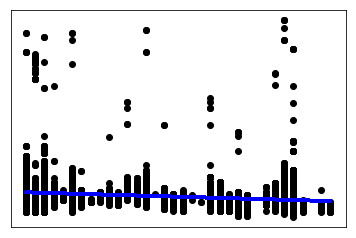

In [18]:
# Train the model using the training sets
regr = linear_model.LinearRegression()
regr.fit(VClass_X_train, VClass_y_train)

# Make predictions using the testing set
VClass_y_pred = regr.predict(VClass_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(VClass_y_test, VClass_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(VClass_y_test, VClass_y_pred))
# Best possible score is 1.0, lower values are worse.
print(explained_variance_score(VClass_y_test, VClass_y_pred))

plt.scatter(VClass_X_train, VClass_y_train,  color='black')
plt.plot(VClass_X_test, VClass_y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [19]:
make_X_train, make_X_test, make_y_train, make_y_test = train_test_split(data[['make_codes']], data[['comb08']])

Coefficients: 
 [[ 0.03372297]]
Mean squared error: 53.29
Variance score: 0.03
0.0263365379744


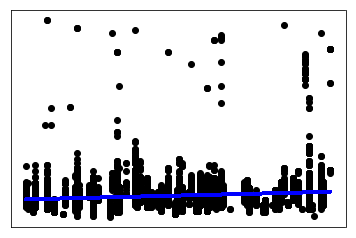

In [20]:
# Train the model using the training sets
regr.fit(make_X_train, make_y_train)

# Make predictions using the testing set
make_y_pred = regr.predict(make_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(make_y_test, make_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(make_y_test, make_y_pred))
# Best possible score is 1.0, lower values are worse.
print(explained_variance_score(make_y_test, make_y_pred))

plt.scatter(make_X_train, make_y_train,  color='black')
plt.plot(make_X_test, make_y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [21]:
fuelType_X_train, fuelType_X_test, fuelType_y_train, fuelType_y_test = train_test_split(data[['fuelType1_codes']], data[['comb08']])

In [22]:
# Train the model using the training sets
regr.fit(VClass_X_train, VClass_y_train)

# Make predictions using the testing set
fuelType_y_pred = regr.predict(fuelType_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(fuelType_y_test, fuelType_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(fuelType_y_test, fuelType_y_pred))
# Best possible score is 1.0, lower values are worse.
print(explained_variance_score(fuelType_y_test, fuelType_y_pred))

# Plot outputs
# plt.scatter(fuelType_X_train, fuelType_y_train,  color='black')
# plt.plot(fuelType_X_test, fuelType_y_pred, color='blue', linewidth=3)
# plt.xticks(())
# plt.yticks(())
# plt.show()

Coefficients: 
 [[-0.1557796]]
Mean squared error: 52.08
Variance score: -0.03
0.00831584357072


In [23]:
vel_X_train, vel_X_test, vel_y_train, vel_y_test = train_test_split(data[['all_velocity']], data[['comb08']])

Coefficients: 
 [[-2.08659852]]
Mean squared error: 52.72
Variance score: 0.02
0.0172414662473


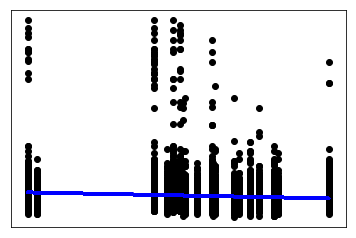

In [24]:
# Train the model using the training sets
regr.fit(vel_X_train, vel_y_train)

# Make predictions using the testing set
vel_y_pred = regr.predict(vel_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(vel_y_test, vel_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(vel_y_test, vel_y_pred))
# Best possible score is 1.0, lower values are worse.
print(explained_variance_score(vel_y_test, vel_y_pred))

plt.scatter(vel_X_train, vel_y_train,  color='black')
plt.plot(vel_X_test, vel_y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()